In [102]:
%matplotlib inline

In [1]:
import datetime
import pandas as pd
import numpy as np
import datetime

In [2]:
import catboost
from catboost import CatBoostClassifier, Pool, cv
import hyperopt

In [3]:
import tqdm

In [4]:
import sklearn.model_selection
from sklearn import model_selection , metrics   #Additional scklearn functions

In [66]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [67]:
from importlib import reload
import src.home_service
reload(src.home_service)
from src.home_service import *

## import and parameters

In [17]:
# methode 4 is the best impute strategy (+1.5 AUC better than methode 3)
imput_strategy = 4

In [15]:
train = pd.read_pickle('../data/merged_data/train.pkl')
test = pd.read_pickle('../data/merged_data/test.pkl')

In [16]:
#train = train.sample(frac=0.1)

In [17]:
# preprocess
y = train['target'].astype(bool)
train['target'] = train['target'].astype(bool)

In [18]:
#y.to_pickle('target.pickle')

## Features : 
* NLP on COMMENTAIRE_BI
* Extract options from OPTION (pas sur que ce soit util, peut être juste check la qualité)
* features from history

* add combinations of categorical features (see paribas example on catboost site)

In [21]:
drop = ['INSTANCE_ID', #460k modalities, not usable as a feature
        'INCIDENT_NUMBER']
drop_atm = [#'AUTEUR_INCIDENT', # 2088 modalities
            'TYPE_VOIE',
#            'NATURE_CODE', # 313 modalities, need to be splitted in 5 modalities
#            'MARQUE_LIB', # 167 modalities
#            'OPTION', # 80 modalities, extract options
            #'MODELE_CODE', # 10k modalities
#            'COMMENTAIRE_BI', # NLP 400k modalities
             #'RESOURCE_ID', # 4033 modalities
            'CODE_POSTAL', # 5800 modalities (only get first 2 numbers ?)
            'L2_ORGA_CODE_POSTAL', # 147 modalities (might be redondent with L2_ORGANISATION_ID)
#            'L2_ORGANISATION_ID' #151 modalities
            'L2_ORGA_VILLE', # 146, might be redondent with other organisation variables
#            'RACHAT_CODE' # 312 modalities (try binarising ?)         
#            'CODE_INSTALLATION' # 17 modalities
           ]

In [22]:
#train.drop(drop + drop_atm + ['target'], axis=1, inplace=True)
train.drop(drop + drop_atm , axis=1, inplace=True)
test.drop(drop + drop_atm, axis=1, inplace=True)

In [23]:
categoricals = list(train.columns[train.dtypes == 'category'])

In [24]:
for cat in categoricals:
    train[cat] = train[cat].cat.remove_unused_categories()

### imputation of missing data

TODO: try imputing test based on test values, not train <br>
TODO: try diffrent strategy on imputing datas from contract since missing are present only in test set<BR>
TODO: try creating data with missing contract in train sample and do not fill the missing in test<br>
TODO: try imputing specific na value for categorical variables

In [25]:
categoricals = list(train.columns[train.dtypes == 'category'])
quantitative = ['NB_PASSAGE', 'POINTS_FIDEL', 'CONTRAT_TARIF', 'PRIX_FACTURE']
dates = list(train.columns[train.dtypes == 'datetime64[ns]'])

In [26]:
contract_variables = [ 'UPD_DATE', 'DATE_DEBUT', 'DATE_FIN', 'STS_CODE', 'OPTION', 'FORMULE', 'CONTRAT_TARIF', 'PRIX_FACTURE']

In [27]:
#impute without contract
categ_to_impute = list(set(categoricals) - set(contract_variables))
quanti_to_impute = list(set(quantitative) - set(contract_variables))
date_to_impute = list(set(dates) - set(contract_variables))

#impute contract
categ_contract = list(set(categoricals).intersection(set(contract_variables)))
quanti_contract = list(set(quantitative).intersection(set(contract_variables)))
date_contract = list(set(dates).intersection(set(contract_variables)))

#train and test are filled with values taken from train
#contract and other variables are imputed together
if imput_strategy == 1:
    train, test = impute_selected_variables(train, test, categoricals, quantitative, dates)

#train and test are filled with values taken on their own values
#contract and other variables are imputed together
if imput_strategy == 2:
    train, _ = impute_selected_variables(train, None, categoricals, quantitative, dates)
    test, _ = impute_selected_variables(test, None, categoricals, quantitative, dates)

#train and test are filled with values taken from train
#contract and other variables are imputed separatly (need to import some NAN in train set)
if imput_strategy == 3:
    train, test = impute_selected_variables(train, test, categ_to_impute, quanti_to_impute, date_to_impute)
    train = impute_contract_variables(train, categ_contract, quanti_contract, date_contract)
    test = impute_contract_variables(test, categ_contract, quanti_contract, date_contract)

# train and test are filled on their own values
# contract and other variables are imputed separatly (need to import some NAN in train set)
if imput_strategy == 4:
    train, _ = impute_selected_variables(train, None, categ_to_impute, quanti_to_impute, date_to_impute)
    test, _ = impute_selected_variables(test, None, categ_to_impute, quanti_to_impute, date_to_impute)
    train = impute_contract_variables(train, categ_contract, quanti_contract, date_contract)
    test = impute_contract_variables(test, categ_contract, quanti_contract, date_contract)

### Feature ingineering

In [28]:
# feature engineering

# (history) temps depuis dernière visite (pas forcément dispo sur le test)
# (history) déjà eu une casse sur ce matériel
# (history) temps depuis dernière casse
# (history) la dernière visite date de moins de 6 mois
# (history) nb interventions faires par la ressource
# (history) temps depuis la première intervention de la ressource
# (contract history) nb de fois que le contrat a été mis à jour sur les X dernières années

In [29]:
#try more variables and differents thresholds
rmg = RareModalitiesGrouper(categoricals + ['COMMENTAIRE_BI'], 200) #uncomment this line to group on more variables"
#rmg = RareModalitiesGrouper(['COMMENTAIRE_BI'], 200)
rmg.fit(train)

RareModalitiesGrouper(columns=['INCIDENT_TYPE_ID', 'TYPE_BI', 'MILLESIME', 'PROBLEM_CODE', 'AUTEUR_INCIDENT', 'ORIGINE_INCIDENT', 'GRAVITE', 'RESOURCE_ID', 'TYPE_OCC', 'RACHAT_CODE', 'NATURE_CODE', 'MARQUE_LIB', 'MODELE_CODE', 'USAGE_LOCAL', 'PAYS', 'STOP_PHONING', 'CODE_GEN_EQUIPEMENT', 'CODE_FONCTION', 'CODE_ENERGIE', 'CODE_INSTALLATION', 'CODE_SPECIFICATION', 'CODE_EAU_CHAUDE', 'L1_ORGANISATION_ID', 'L2_ORGANISATION_ID', 'STS_CODE', 'FORMULE', 'OPTION', 'COMMENTAIRE_BI'],
           min_occurences=200)

In [30]:
train = commentaire_bi(train)
train = rmg.transform(train)
train = nature_code_split(train)
train = add_dates_features(train)
train = add_features_from_file(train, 'features_canceled_train.csv')

In [31]:
test = commentaire_bi(test)
test = rmg.transform(test)
test = nature_code_split(test)
test = add_dates_features(test)
test = add_features_from_file(test, 'features_canceled_test.csv')

In [32]:
#drop variables
#drop = ['joursemaine_appel', 'USAGE_LOCAL', 'nc_4', 'is_empty_commentaire', 'duree_prevue', 'nc_1']

#train.drop(drop, axis=1,inplace=True)
#test.drop(drop, axis=1,inplace=True)

### standard scale numeric variables

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
sc = StandardScaler()

nums = train.select_dtypes(include=['number']).columns
train.loc[:, nums] = sc.fit_transform(train[nums])
test.loc[:, nums] = sc.transform(test[nums])

## Get variables where test set has modalities which are not in train set

In [35]:
categoricals = list(train.columns[train.dtypes == 'category'])
var_with_new_categ = []
for cat in categoricals:
    if len(set(test[cat]) - set(train[cat])) > 0:
        var_with_new_categ.append(cat)

# drop categories in test which are not in train

In [36]:
cd = CategoriesDroper(categoricals)
cd.fit(train)
test = cd.transform(test)

## save preprocessed file

In [37]:
for item in train.select_dtypes(include=['category']).columns:
    train[item] = train[item].cat.codes
    test[item] = test[item].cat.codes

In [38]:
train.to_pickle('train_preproc_rare.pickle')
test.to_pickle('test_preproc_rare.pickle')
#train = pd.read_pickle('train_preproc_1_.pickle')
#test = pd.read_pickle('test_preproc_1_.pickle')

### load reworked data

In [150]:
train = pd.read_pickle('../data/preproc/trainid.pickle')
test = pd.read_pickle('../data/preproc/testid.pickle')
y = pd.read_pickle('target.pickle')

In [88]:
# variables to drop
#["duree_prevue", "PAYS"]

In [151]:
categoricals = train.select_dtypes(include=['int8', 'int16', 'int32', 'int64']).columns
categorical_features_indices = [X_train_train.columns.get_loc(cat) for cat in categoricals]
train.loc[:, categoricals] = train.loc[:, categoricals].astype('category')
test.loc[:, categoricals] = test.loc[:, categoricals].astype('category')

rmg = RareModalitiesGrouper(categoricals, 2000) #uncomment this line to group on more variables"
rmg.fit(train)

train = rmg.transform(train)
test = rmg.transform(test)

cd = CategoriesDroper(categoricals)
cd.fit(train)
test = cd.transform(test)

# Modelisation

### split train / val

In [85]:
#for item in categoricals:
#    train[item] = train[item].cat.codes +1

In [90]:
# split train in train, cv (will be replaced by cross validation for parameters tuning)
# stratify ?
X_train_train, X_train_val, y_train_train, y_train_val = sklearn.model_selection.train_test_split(train, y, random_state=101)

In [91]:
pos_neg_ratio =  sum(y==False) / sum(y==True)

In [92]:
#combinations_ctr for list of variables ?
model = CatBoostClassifier(
    iterations=30,
#    one_hot_max_size=3,
#    learning_rate=0.16,
#    depth=8,
    eval_metric="AUC",
    random_seed=42,
    od_type='Iter',
    od_wait=40,
    use_best_model=True
#    scale_pos_weight=pos_neg_ratio
)

In [93]:
model.fit(
    X_train_train, y_train_train,
    cat_features=categorical_features_indices,
    eval_set=(X_train_val, y_train_val),
    logging_level='Verbose'  # you can uncomment this for text output
)

Learning rate set to 0.5
0:	test: 0.7048196	best: 0.7048196 (0)	total: 5.9s	remaining: 2m 51s
1:	test: 0.7133831	best: 0.7133831 (1)	total: 11.5s	remaining: 2m 40s
2:	test: 0.7165271	best: 0.7165271 (2)	total: 17.3s	remaining: 2m 35s
3:	test: 0.7191173	best: 0.7191173 (3)	total: 22.7s	remaining: 2m 27s
4:	test: 0.7209861	best: 0.7209861 (4)	total: 27.7s	remaining: 2m 18s
5:	test: 0.7234351	best: 0.7234351 (5)	total: 33s	remaining: 2m 12s
6:	test: 0.7249254	best: 0.7249254 (6)	total: 38.2s	remaining: 2m 5s
7:	test: 0.7256874	best: 0.7256874 (7)	total: 44s	remaining: 2m
8:	test: 0.7262397	best: 0.7262397 (8)	total: 49.6s	remaining: 1m 55s
9:	test: 0.7270783	best: 0.7270783 (9)	total: 55.2s	remaining: 1m 50s
10:	test: 0.7274965	best: 0.7274965 (10)	total: 1m	remaining: 1m 45s
11:	test: 0.7279137	best: 0.7279137 (11)	total: 1m 6s	remaining: 1m 39s
12:	test: 0.7300162	best: 0.7300162 (12)	total: 1m 11s	remaining: 1m 33s
13:	test: 0.7303572	best: 0.7303572 (13)	total: 1m 16s	remaining: 1m 26

### Feature importance

In [75]:
importances=model.feature_importances_

In [76]:
indices = np.argsort(model.feature_importances_)[::-1]

print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. %s (%f)" % (f + 1, train.columns[indices[f]], model.feature_importances_[indices[f]]))

Feature ranking:
1. canceled_proba_pred (58.033062)
2. duree_avant_intervention (10.150283)
3. INCIDENT_TYPE_ID (4.351325)
4. nb_char_commentaire (3.708904)
5. MILLESIME_plus_mois_intervention (3.124811)
6. joursemaine_intervention_plus_jour_intervention (2.594554)
7. mois_intervention (1.704943)
8. CODE_FONCTION (1.413812)
9. INCIDENT_TYPE_ID_plus_mois_appel (1.339692)
10. COMMENTAIRE_BI (1.288806)
11. PRIX_FACTURE (1.198452)
12. L2_ORGANISATION_ID (1.182485)
13. MODELE_CODE (1.107173)
14. NATURE_CODE_plus_MARQUE_LIB (1.079399)
15. age_installation (0.780150)
16. FORMULE (0.579590)
17. STS_CODE_plus_FORMULE (0.564346)
18. MARQUE_LIB (0.539566)
19. MILLESIME_plus_L2_ORGANISATION_ID (0.479335)
20. nb_mots_commentaire (0.405414)
21. L1_ORGANISATION_ID_plus_FORMULE (0.384501)
22. NB_PASSAGE (0.384143)
23. RESOURCE_ID (0.353280)
24. CODE_INSTALLATION (0.327919)
25. COMMENTAIRE_BI_plus_GRAVITE (0.295492)
26. RACHAT_CODE_plus_NATURE_CODE (0.264385)
27. STOP_PHONING (0.222612)
28. L1_ORGANISA

In [ ]:
import matplotlib.pyplot as plt

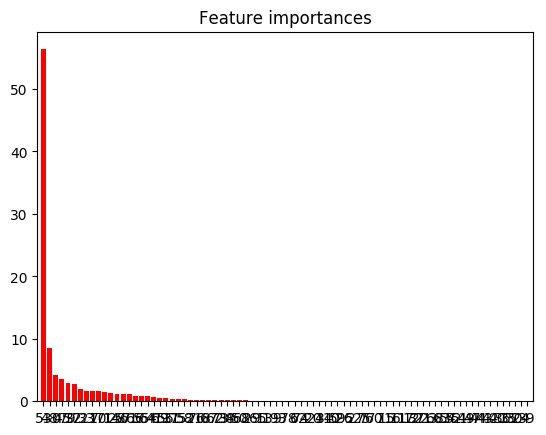

In [44]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()

### Hyperparameter tunning

In [ ]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

#### GridSearch

In [ ]:
from sklearn.grid_search import GridSearchCV

In [ ]:
#what to do with cat features
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.20, 0.31, 0.40],
         'l2_leaf_reg': [1, 4, 9],
         'iterations': [300]}
cb = CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc")
cb_model.fit(train, y_train, cb__cat_features=categorical_features_indices)

#### hyperopt

In [ ]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=int(params['iterations']),
        border_count=int(params['border_count']),
        eval_metric='AUC',
        random_seed=42,
        logging_level='Silent'
        #od_type='Iter',
        #od_wait=40
    )
    
    cv_data = cv(
        Pool(train, y_train, cat_features=categorical_features_indices),
        model.get_params(),
        stratified=True,
        fold_count=5
    )
    best_AUC = np.max(cv_data['test-AUC-mean'])
    print(params, 'best_AUC: ', best_AUC)
    
    return 1 - best_AUC # as hyperopt minimises

In [ ]:
#param space example for xgboost
#    space = {
#             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
#             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
#             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
#             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
#             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
#             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
#             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#             'num_class' : 9,
#             'eval_metric': 'mlogloss',
#             'objective': 'multi:softprob',
#             'nthread' : 6,
#             'silent' : 1
#}

In [ ]:
from numpy.random import RandomState

params_space = {
    #'l2_leaf_reg': hyperopt.hp.loguniform('l2_leaf_reg', -1, np.log(50)),
    'l2_leaf_reg': hyperopt.hp.choice('l2_leaf_reg', [11.47871028241772]),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-1, 8e-1),
     #'learning_rate': hyperopt.hp.choice('learning_rate', [0.31]),
    'iterations': hyperopt.hp.quniform('iterations', 250, 1000, 1),
    #'iterations': hyperopt.hp.choice('iterations', [250]),
    #'depth': hyperopt.hp.quniform('depth', 3, 9, 1),
    'depth': hyperopt.hp.choice('depth', [7]),
#    'ctr_border_count': hyperopt.hp.quniform('ctr_border_count', 32, 255, 1),
    #'border_count': hyperopt.hp.quniform('border_count', 16, 255, 1)
    'border_count': hyperopt.hp.choice('border_count', [213])
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=8,
    trials=trials,
    rstate=RandomState(123)
    
)

print(best)

#round 1
{'depth': 7.0, 'l2_leaf_reg': 6.687638927479829} best_AUC:  0.764339203919555
{'depth': 8.0, 'l2_leaf_reg': 2.238434810070511} best_AUC:  0.7641940842160905
{'depth': 9.0, 'l2_leaf_reg': 15.61615505112418} best_AUC:  0.7656179177534072
{'depth': 7.0, 'l2_leaf_reg': 11.47871028241772} best_AUC:  0.766724797438951
{'depth': 6.0, 'l2_leaf_reg': 2.0946141383866816} best_AUC:  0.7641940842160905
{'depth': 5.0, 'l2_leaf_reg': 3.409700409045487} best_AUC:  0.7656396435014416
{'l2_leaf_reg': 11.47871028241772, 'learning_rate': 7.0}

#round 2
{'border_count': 199.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7654693707749893
{'border_count': 213.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7662068818039395
{'border_count': 105.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7639026943327258
{'border_count': 238.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.764574925126635
{'border_count': 22.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7643064612539859
{'border_count': 103.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7632638136706521
{'border_count': 225.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7653002122083675
{'border_count': 212.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649391813119792
{'border_count': 85.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649657537494025
{'border_count': 251.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649243873489558
{'border_count': 213.0, 'depth': 0, 'iterations': 0, 'l2_leaf_reg': 0, 'learning_rate': 0}

#round 3
{'border_count': 213, 'depth': 7, 'iterations': 693.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.6096210638782021} best_AUC:  0.767539056284941
{'border_count': 213, 'depth': 7, 'iterations': 526.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.701085638831484} best_AUC:  0.767228088670764
{'border_count': 213, 'depth': 7, 'iterations': 822.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.7947626751796161} best_AUC:  0.7647414699770261
{'border_count': 213, 'depth': 7, 'iterations': 775.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.571434077994127} best_AUC:  0.7686875566115616
{'border_count': 213, 'depth': 7, 'iterations': 516.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.4938304425560929} best_AUC:  0.7680238623609622


In [ ]:
#check quality to expect
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='AUC',
    random_seed=42,
    logging_level='Silent'
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [ ]:
print('Precise validation AUC score: {}'.format(np.max(cv_data['test-AUC-mean'])))

### Make submission

In [78]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [94]:
pos_neg_ratio =  sum(y==False) / sum(y==True)

In [95]:
params = {
          'border_count': 64, 
#          'one_hot_max_size': 5,
#          'depth': 7,
#          'depth': 5,
          'iterations': 30.0,
#          'l2_leaf_reg': 11.47871028241772, 
          'learning_rate': 0.31,
#          'scale_pos_weight': pos_neg_ratio
          'thread_count': 3
         }

#random_strength (default 1)

model = CatBoostClassifier(
    **params,
    eval_metric="AUC",
    od_type='Iter',
    od_wait=40
)

model.fit(train, y, cat_features=categorical_features_indices)

In [97]:
#save model to disk
#model.save_model('catboost_model.dump')
#load
#model = CatBoostClassifier()
#model.load_model('catboost_model.dump')

In [98]:
submission = model.predict_proba(test)[:, 1]

In [99]:
filename = str(datetime.datetime.now())[:-7] + '_submission.csv'
create_submission_file(submission, "catboost_", params)

30 iteration et tout libre (peut être pas canceled_proba): 0.7267220863
30 iterations et 2000 rare: 0.7238

### tests on cross validation

In [ ]:
pos_neg_ratio =  sum(y_train==0) / sum(y_train==1)

categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

params = {
          'border_count': 64, 
#          'one_hot_max_size': 5,
#          'depth': 7,
#          'depth': 5,
          'iterations': 30.0,
#          'l2_leaf_reg': 11.47871028241772, 
          'learning_rate': 0.31,
#          'scale_pos_weight': pos_neg_ratio
          'thread_count': 3
         }

In [100]:
cv_data = cv(
    Pool(train, y, cat_features=categorical_features_indices),
    model.get_params(),
    stratified=True,
    fold_count=5
)

#0.707 on test set

0:	learn: 0.7044502	test: 0.7041395	best: 0.7041395 (0)	total: 39.6s	remaining: 19m 8s
1:	learn: 0.7099353	test: 0.7096423	best: 0.7096423 (1)	total: 1m 14s	remaining: 17m 20s
2:	learn: 0.7132449	test: 0.7128876	best: 0.7128876 (2)	total: 1m 47s	remaining: 16m 8s
3:	learn: 0.7163935	test: 0.7160689	best: 0.7160689 (3)	total: 2m 22s	remaining: 15m 26s
4:	learn: 0.7187156	test: 0.7183820	best: 0.7183820 (4)	total: 2m 54s	remaining: 14m 30s
5:	learn: 0.7203775	test: 0.7200341	best: 0.7200341 (5)	total: 3m 26s	remaining: 13m 45s
6:	learn: 0.7221576	test: 0.7219488	best: 0.7219488 (6)	total: 4m 2s	remaining: 13m 15s
7:	learn: 0.7236407	test: 0.7235785	best: 0.7235785 (7)	total: 4m 34s	remaining: 12m 35s
8:	learn: 0.7261372	test: 0.7267762	best: 0.7267762 (8)	total: 5m 6s	remaining: 11m 55s
9:	learn: 0.7271506	test: 0.7278630	best: 0.7278630 (9)	total: 5m 39s	remaining: 11m 19s
10:	learn: 0.7279659	test: 0.7288522	best: 0.7288522 (10)	total: 6m 14s	remaining: 10m 46s
11:	learn: 0.7287513	tes

In [105]:
cv_data

,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0.704139,0.002146,0.704450,0.001620,0.579722,0.001166,0.579642,0.000906
1,0.709642,0.002370,0.709935,0.000398,0.536618,0.000763,0.536492,0.000288
2,0.712888,0.002192,0.713245,0.000706,0.518551,0.000737,0.518393,0.000258
3,0.716069,0.001659,0.716394,0.000788,0.509873,0.000774,0.509709,0.000143
4,0.718382,0.001644,0.718716,0.000822,0.505179,0.000760,0.505014,0.000245
5,0.720034,0.001725,0.720378,0.000431,0.502617,0.000806,0.502444,0.000236
6,0.721949,0.002057,0.722158,0.000854,0.500601,0.000830,0.500468,0.000399
7,0.723579,0.002796,0.723641,0.000934,0.499046,0.001156,0.498964,0.000280
8,0.726776,0.002031,0.726137,0.001059,0.497175,0.001079,0.497375,0.000516
9,0.727863,0.001740,0.727151,0.000782,0.496326,0.000791,0.496567,0.000445


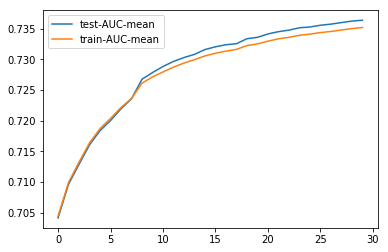

In [103]:
cv_data.plot(y=['test-AUC-mean', 'train-AUC-mean'])

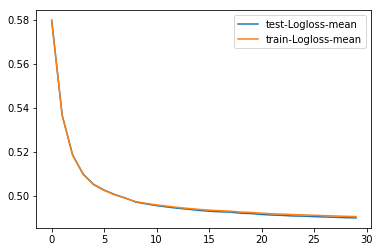

In [104]:
cv_data.plot(y=['test-Logloss-mean', 'train-Logloss-mean'])

### train with some randomly added na for contract variables
must be done before all feature engineering ? --> not necessarily (if variable identification is possible)

In [193]:
train.drop('target', axis=1, inplace=True)

In [194]:
var_with_new_categ_not_in_contract = [var for var in var_with_new_categ if var not in categ_contract]

In [195]:
quanti_contract = ['PRIX_FACTURE', 
                   'CONTRAT_TARIF',
                   'temps_depuis_debut_contrat',
                   'temps_jusqua_fin_contrat', 
                   'temps_depuis_maj_contrat']

In [196]:
variables = categ_contract + var_with_new_categ_not_in_contract
train = add_categories_in_columns(train, variables, ['NAN'])
test = add_categories_in_columns(test, variables, ['NAN'])

In [197]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [198]:
models = []

params = {'iterations': 30,
          'border_count': 64,
          'learning_rate':0.30
}

for i in tqdm.tqdm_notebook(range(10)):
    _train = train.copy()
    
    _train = randomly_alter_modalities_on_same_line(_train, categ_contract, quanti_contract, 0.2)
    _train = randomly_alter_modalities(_train, var_with_new_categ_not_in_contract, 0.2)

    model = CatBoostClassifier(
        **params,
        verbose=False
    )
    
    model.fit(_train, y, cat_features=categorical_features_indices)
    models.append(model.copy())

In [199]:
predictions = []
for _model in tqdm.tqdm_notebook(models):
    predictions.append(_model.predict_proba(test)[:,1])
    
submission = np.vstack(predictions).T.mean(axis=1)
create_submission_file(submission, "catboost_rdmNA", params)

In [43]:
#prediction if multiple models
#prediction = np.hstack([predictions, predictions2]).mean(axis=1)

## LightGBM

In [106]:
import lightgbm

model_gbm = lightgbm.LGBMClassifier(
    seed=np.random.randint(10**10),
    n_estimators=70,
    max_depth=20,
    num_leaves=200,
    min_data_in_leaf=100,
    subsample=0.8,
    colsample_bytree=0.8,
    is_unbalance=True,
    objective='binary'
)

model_gbm.fit(X_train_train, y_train_train, 
              eval_set=[(X_train_val, y_train_val)], 
              eval_metric='auc', 
              categorical_feature=categorical_features_indices)

/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.710839
[2]	valid_0's auc: 0.71554
[3]	valid_0's auc: 0.717831
[4]	valid_0's auc: 0.719205
[5]	valid_0's auc: 0.720907
[6]	valid_0's auc: 0.721476
[7]	valid_0's auc: 0.721819
[8]	valid_0's auc: 0.722246
[9]	valid_0's auc: 0.722731
[10]	valid_0's auc: 0.723095
[11]	valid_0's auc: 0.723503
[12]	valid_0's auc: 0.723551
[13]	valid_0's auc: 0.723741
[14]	valid_0's auc: 0.723942
[15]	valid_0's auc: 0.7239
[16]	valid_0's auc: 0.724123
[17]	valid_0's auc: 0.72433
[18]	valid_0's auc: 0.724458
[19]	valid_0's auc: 0.724714
[20]	valid_0's auc: 0.724784
[21]	valid_0's auc: 0.725117
[22]	valid_0's auc: 0.725347
[23]	valid_0's auc: 0.725492
[24]	valid_0's auc: 0.72563
[25]	valid_0's auc: 0.725893
[26]	valid_0's auc: 0.72617
[27]	valid_0's auc: 0.7263
[28]	valid_0's auc: 0.726396
[29]	valid_0's auc: 0.726535
[30]	valid_0's auc: 0.726579
[31]	valid_0's auc: 0.726779
[32]	valid_0's auc: 0.726998
[33]	valid_0's auc: 0.727111
[34]	valid_0's auc: 0.727201
[35]	valid_0's auc: 0.727339
[3

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        is_unbalance=True, learning_rate=0.1, max_depth=10,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=70, n_jobs=-1, num_leaves=200,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, seed=1704567630, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0)

## H2O random forest
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-search-in-python

TODO: assembling categorical features (see stacknet tutorial)
TODO: compare LB to val score
TODO: hyper parameter optimization

In [8]:
import h2o

In [9]:
h2o.init(nthreads=2, max_mem_size = "8G")             #specify max number of bytes. uses all cores by default.
h2o.remove_all() #clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/cn/_vkc1v4550g_s2ck0c34d7zr0000gp/T/tmp4vby9s28
  JVM stdout: /var/folders/cn/_vkc1v4550g_s2ck0c34d7zr0000gp/T/tmp4vby9s28/h2o_WM1158_started_from_python.out
  JVM stderr: /var/folders/cn/_vkc1v4550g_s2ck0c34d7zr0000gp/T/tmp4vby9s28/h2o_WM1158_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_WM1158_n5dzt5
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [138]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid import H2OGridSearch

In [152]:
train['target'] = y

In [18]:
categoricals = train.select_dtypes(include=['int8', 'int16', 'int32', 'int64']).columns
#categorical_features_indices = [X_train_train.columns.get_loc(cat) for cat in categoricals]
train.loc[:, categoricals] = train.loc[:, categoricals].astype('category')

test.loc[:, categoricals] = test.loc[:, categoricals].astype('category')

cd = CategoriesDroper(categoricals)
cd.fit(train)
test = cd.transform(test)

In [141]:
#covtype_df = h2o.import_file(os.path.realpath("../data/covtype.full.csv"))
#convert df to H2O df type
train_H2O = h2o.H2OFrame(train)
test_h2O = h2o.H2OFrame(test)

/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [142]:
#split the data as described above
#X_train, X_valid, X_test = train_H2O.split_frame([0.60, 0.20], seed=1234)
X_train, X_valid = train_H2O.split_frame([0.75], seed=1234)

In [144]:
#Prepare predictors and response columns
X = train_H2O.col_names     #last column is Cover_Type, our desired response variable 
X.remove('target')
y = 'target'

In [24]:
params = {}

rf_v1 = H2ORandomForestEstimator(
    model_id="rf_v1",
    ntrees=100,
    stopping_rounds=2,
    score_each_iteration=False,
    seed=1000000)

In [25]:
rf_v1.train(X, y, training_frame=X_train, validation_frame=X_valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [28]:
sklearn.metrics.roc_auc_score(X_valid['target'].as_data_frame(), rf_v1.predict(X_valid[X])[2].as_data_frame())

drf prediction progress: |████████████████████████████████████████████████| 100%


0.7235783516874486

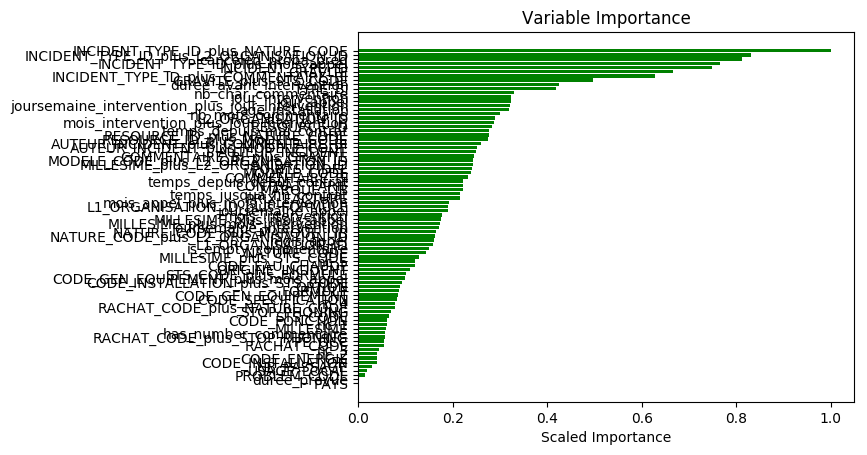

In [33]:
import matplotlib.pyplot as plt
plt.rcdefaults()
fig, ax = plt.subplots()
variables = rf_v1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = rf_v1._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

In [35]:
rf_v1._model_json['output']['variable_importances']

Variable Importances: 


variable,relative_importance,scaled_importance,percentage
INCIDENT_TYPE_ID_plus_NATURE_CODE,158667.0,1.0,0.0557487
INCIDENT_TYPE_ID_plus_L2_ORGANISATION_ID,131864.2812500,0.8310757,0.0463314
canceled_proba_pred,129055.3437500,0.8133723,0.0453444
INCIDENT_TYPE_ID_plus_mois_appel,121480.6796875,0.7656329,0.0426830
INCIDENT_TYPE_ID,118892.3046875,0.7493197,0.0417736
---,---,---,---
NB_PASSAGE,4729.4462891,0.0298074,0.0016617
USAGE_LOCAL,2970.4482422,0.0187213,0.0010437
PROBLEM_CODE,2183.8430176,0.0137637,0.0007673
duree_prevue,41.9812012,0.0002646,0.0000148



See the whole table with table.as_data_frame()


#### hyperopt h2o
https://github.com/h2oai/h2o-tutorials/blob/master/h2o-open-tour-2016/chicago/grid-search-model-selection.ipynb

In [146]:
# GBM hyperparameters
gbm_params2 = {'learn_rate': [i * 0.01 for i in range(1, 11)], 
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria2 = {'strategy': 'RandomDiscrete', 'max_models': 36}

In [153]:
gbm_grid2  = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid2',
                          hyper_params=gbm_params2,
                          search_criteria=search_criteria2)

gbm_grid2.train(x=X, y=y, 
                training_frame=X_train,
                validation_frame=X_valid, 
                ntrees=100,
                balance_classes=True,
                stopping_metric='AUC',
                stopping_rounds=5,
                seed=1)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [ ]:
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [ ]:
print gbm_gridperf2

### submission

In [34]:
params = {'ntrees':24}

rf = H2ORandomForestEstimator(
    model_id="rf",
    seed=1000000)

In [38]:
rf.train(covtype_X, covtype_y, training_frame=train_H2O)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [51]:
submission = rf.predict(test_h2O).as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


/home/julien/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'RACHAT_CODE' has levels not trained on: [NAN]
  warnings.warn(w)
/home/julien/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'NATURE_CODE' has levels not trained on: [NAN]
  warnings.warn(w)
/home/julien/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'MODELE_CODE' has levels not trained on: [NAN]
  warnings.warn(w)
/home/julien/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'CODE_GEN_EQUIPEMENT' has levels not trained on: [NAN]
  warnings.warn(w)
/home/julien/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'CODE_FONCTION' has levels not trained on: [NAN]
  warnings.warn(w)
/home/julien/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 

In [ ]:
create_submission_file(submission, "H2O_RF", params)

## LR

0.71

In [119]:
from sklearn.preprocessing import OneHotEncoder
#from scipy.sparse import csr_matrix,csc_matrix
from sklearn.cross_validation import StratifiedKFold
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
#from sklearn.preprocessing import LabelEncoder

In [112]:
categoricals = train.select_dtypes(include=['category']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [113]:
for item in train.select_dtypes(include=['category']).columns:
    train[item] = train[item].cat.codes
    test[item] = test[item].cat.codes

In [117]:
kfolder = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=1)
grand_auc = 0

X = np.array(train)
i=0 # iterator counter
#model = SGDClassifier(loss='log', penalty='l2', alpha=0.0030, max_iter=30, random_state=1)
#model = SGDClassifier(loss="hinge", alpha=0.01, max_iter=30)

for train_index, test_index in kfolder:
        X_train, X_cv = np.array(X)[train_index], np.array(X)[test_index]
        y_train, y_cv = np.array(y)[train_index], np.array(y)[test_index]
        one=OneHotEncoder(handle_unknown='ignore', categorical_features=categorical_features_indices)
        one.fit(X_train)
        X_train=one.transform(X_train)
        X_cv=one.transform(X_cv)
        model.fit(X_train,y_train)
        preds=model.predict_proba(X_cv)[:,1]
        auc=roc_auc_score(y_cv,preds)
        print (" fold %d/%d auc %f " % (i+1, 5, auc))
        grand_auc+=auc
        i+=1
grand_auc/=5
print ("grand AUC is %f " % (grand_auc))

AttributeError: probability estimates are not available for loss='hinge'

In [122]:
model = LogisticRegressionCV(scoring='roc_auc')
#one=OneHotEncoder(handle_unknown='ignore', categorical_features=categorical_features_indices)
#one.fit(X)
#X=one.transform(X)
#X_cv=one.transform(X_cv)
model.fit(X, y)
#preds=model.predict_proba(X_cv)[:,1]
#auc=roc_auc_score(y_cv,preds)
#print (" fold %d/%d auc %f " % (i+1, 5, auc))


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

In [125]:
model.C_

array([0.00599484])

In [127]:
one=OneHotEncoder(handle_unknown='ignore', categorical_features=categorical_features_indices)
one.fit(train)
test_ohe=one.transform(test)
submission = model.predict_proba(test_ohe)[:,1]

array([0.39875361, 0.16195149, 0.08336156, ..., 0.21348615, 0.08730254,
       0.24835877])

In [128]:
submission = model.predict_proba(test_ohe)[:,1]

In [129]:
create_submission_file(submission, "LR_l2_", {'C': 0.00599484})